In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import torch

data_path = "../data/reaxys_output_local/For_second_part_model/Splitted_second_train_labels_processed.txt"
reagent_path = "../data/reaxys_output_local/label_processed/class_names_reagent_labels_processed.pkl"
solvent_path = "../data/reaxys_output_local/label_processed/class_names_solvent_labels_processed.pkl"
random.seed(11)

def remove_duplicated_records(records):
    return '; '.join(list(dict.fromkeys(records.split('; '))))

def sort_out_data(data):
    data = [line.strip('\n').split('\t') for line in data]
    sorted_data = []
    rxn_id = ''
    j = -1
    for i in range(len(data)):
        if rxn_id != data[i][0]:
            j += 1
            sorted_data.append([data[i][0], data[i][1], data[i][2], []])
            y_ = data[i][3]; r_ = remove_duplicated_records(data[i][4]);
            s_ = remove_duplicated_records(data[i][5]); t_ = data[i][6];
            sorted_data[j][3].append((y_, r_, s_, t_))
            rxn_id = data[i][0]
        else:
            if (r_ == remove_duplicated_records(data[i][4])) & (s_ == remove_duplicated_records(data[i][5])):
                pass
            else:
                y_ = data[i][3]; r_ = remove_duplicated_records(data[i][4]);
                s_ = remove_duplicated_records(data[i][5]); t_ = data[i][6];
                sorted_data[j][3].append((y_, r_, s_, t_))
    return sorted_data

In [2]:
with open(data_path, 'r',encoding='UTF-8') as f:
    data = f.readlines()
data = sort_out_data(data)

def get_classes(path):
    f = open(path, 'rb')
    dict_ = pickle.load(f)
    f.close()
    classes = sorted(dict_.items(), key=lambda d: d[1],reverse=True)
    classes = [(x,y) for x,y in classes]
    return classes

reagent_class = get_classes(reagent_path)
solvent_class = get_classes(solvent_path)

In [3]:
for l in data:
    if l[0] == '9079015':
        break
print(l)

['9079015', 'CC1=CC=C(Cl)C=C1.NC1CCCCC1', 'CC1=CC=C(NC2CCCCC2)C=C1', [('96', 'potassium phosphate', 'dimethyl sulfoxide', '80.0'), ('93', 'potassium tert-butylate', '1,4-dioxane', '110.0'), ('92', 'potassium 2-methylbutan-2-olate', '1,2-dimethoxyethane', '80.0'), ('88', "(N,N'-diarylimidazol-2-ylidene)-based palladacycle; sodium t-butanolate", '1,4-dioxane', '70.0'), ('86', 'sodium t-butanolate', '1,4-dioxane', '110.0'), ('83', 'potassium phosphate; copper(l) iodide; N1,N2-bis(2,4,6-trimethoxyphenyl)oxalamide', 'dimethyl sulfoxide', '120.0'), ('81', 'tris-(dibenzylideneacetone)dipalladium(0); C33H48N7P; sodium t-butanolate', 'toluene', '80.0'), ('70', 'sodium t-butanolate', 'toluene', '105.0')]]


In [4]:
# sample fake reaction contexts
reaction = l[1] + '>>' + l[2]
print(reaction)

yields, reagents, solvents, temperatures = list(zip(*l[3]))
reagent_used = []; solvent_used = []
for reag, solv in zip(reagents, solvents):
    reag = reag.split('; ')
    solv = solv.split('; ')
    reagent_used.extend(reag)
    solvent_used.extend(solv)
reagent_used = set(reagent_used)
solvent_used = set(solvent_used)
all_reagent = list(zip(*reagent_class))[0]
all_solvent = list(zip(*solvent_class))[0]
exclude_reagent = [x for x in all_reagent if x not in reagent_used]
exclude_solvent = [x for x in all_solvent if x not in solvent_used]

yields = list(yields)
reagents = list(reagents)
solvents = list(solvents)
print(reagents)
print(solvents)

CC1=CC=C(Cl)C=C1.NC1CCCCC1>>CC1=CC=C(NC2CCCCC2)C=C1
['potassium phosphate', 'potassium tert-butylate', 'potassium 2-methylbutan-2-olate', "(N,N'-diarylimidazol-2-ylidene)-based palladacycle; sodium t-butanolate", 'sodium t-butanolate', 'potassium phosphate; copper(l) iodide; N1,N2-bis(2,4,6-trimethoxyphenyl)oxalamide', 'tris-(dibenzylideneacetone)dipalladium(0); C33H48N7P; sodium t-butanolate', 'sodium t-butanolate']
['dimethyl sulfoxide', '1,4-dioxane', '1,2-dimethoxyethane', '1,4-dioxane', '1,4-dioxane', 'dimethyl sulfoxide', 'toluene', 'toluene']


In [5]:
# generate fake reaction conditions
num_fakes = 12
num_reals = len(yields)

random.seed(17)
fake_reagents = []; fake_solvents = []; fake_yields = []
for i in range(num_fakes):
    fake_reagents.append( '; '.join(random.sample(exclude_reagent, random.randint(1,3))) )
    fake_solvents.append( '; '.join(random.sample(exclude_solvent, random.randint(1,2))) )
    fake_yields.append(0)

context_yields = yields + fake_yields
context_reagents = reagents + fake_reagents
context_solvents = solvents + fake_solvents

# Example data, reaction ID: 9079015

In [6]:
def Yield2Relevance(yields):
    """Context datapoint only saves yield, not relevance. -1 means padding, so do not use -1. """
    if (type(yields) == str) or (type(yields) == float):
        num = float(yields)
        # if num >= 0.70: return 4
        # elif num >= 0.3: return 3
        # elif num > 0: return 2
        if num > 0:
            return num * 2 + 2 # sort of scaling factor
        else: return 0
    
    relevance = []
    for num in yields:
        num = float(num)/100
        relevance.append(Yield2Relevance(num))
        # if num >= 0.70: relevance.append(4)
        # elif num >= 0.3: relevance.append(3)
        # elif num > 1: relevance.append(2)
        # elif num == 1: relevance.append(0.5) # TODO: 改回來
        # else: relevance.append(0)
    return relevance # torch.Tensor(relevance).view(-1,1)


yields = np.exp(Yield2Relevance(context_yields))
yield_distribution = [x/sum(yields) for x in yields]


In [7]:
# generate the texts
art_real = []
art_fake = []
def shorten(word):
    if len(word) >= 19:
        word = word[:19] + '...'
    return word

for k, (y, r, s) in enumerate(zip(context_yields, context_reagents, context_solvents)):
    words = str(k+1)+'. '+str(y)+'%'+' / '+shorten(r)+' / '+s
    if k < num_reals:
        art_real.append(words)
    else:
        art_fake.append(words)
texts_real = '\n'.join(art_real)
texts_fake = '\n'.join(art_fake)
print(texts_real)
print(texts_fake)

1. 96% / potassium phosphate... / dimethyl sulfoxide
2. 93% / potassium tert-buty... / 1,4-dioxane
3. 92% / potassium 2-methylb... / 1,2-dimethoxyethane
4. 88% / (N,N'-diarylimidazo... / 1,4-dioxane
5. 86% / sodium t-butanolate... / 1,4-dioxane
6. 83% / potassium phosphate... / dimethyl sulfoxide
7. 81% / tris-(dibenzylidene... / toluene
8. 70% / sodium t-butanolate... / toluene
9. 0% / S-benzyl isothiouro... / carbon disulfide; dibutyl diglyme
10. 0% / zinc perchlorate; 1... / pentan-3-one
11. 0% / Ni2(N,N-bis(2,6-dii... / decalin; o-xylene
12. 0% / silver hexafluoroan... / acetate buffer
13. 0% / manganese; pipecoli... / ethanol
14. 0% / silver(I) bromide; ... / decane; ethyl acetate
15. 0% / C42H33N3O2; N,N?-di... / butan-1-ol
16. 0% / C56H47N5O4S2; coppe... / acetonitrile; cyclopentyl methyl ether
17. 0% / bismuth; magnesium / pentane; nitromethane
18. 0% / (E)-1,4-bis(2,2-dio... / N,N-dimethyl-formamide; iso-butanol
19. 0% / cobalt(II) bromide-... / tetralin
20. 0% / sodium phenyl

Text(8.9, 0.032, '9. 0% / S-benzyl isothiouro... / carbon disulfide; dibutyl diglyme\n10. 0% / zinc perchlorate; 1... / pentan-3-one\n11. 0% / Ni2(N,N-bis(2,6-dii... / decalin; o-xylene\n12. 0% / silver hexafluoroan... / acetate buffer\n13. 0% / manganese; pipecoli... / ethanol\n14. 0% / silver(I) bromide; ... / decane; ethyl acetate\n15. 0% / C42H33N3O2; N,N?-di... / butan-1-ol\n16. 0% / C56H47N5O4S2; coppe... / acetonitrile; cyclopentyl methyl ether\n17. 0% / bismuth; magnesium / pentane; nitromethane\n18. 0% / (E)-1,4-bis(2,2-dio... / N,N-dimethyl-formamide; iso-butanol\n19. 0% / cobalt(II) bromide-... / tetralin\n20. 0% / sodium phenylsulfon... / ISOPROPYLAMIDE; aq. phosphate buffer')

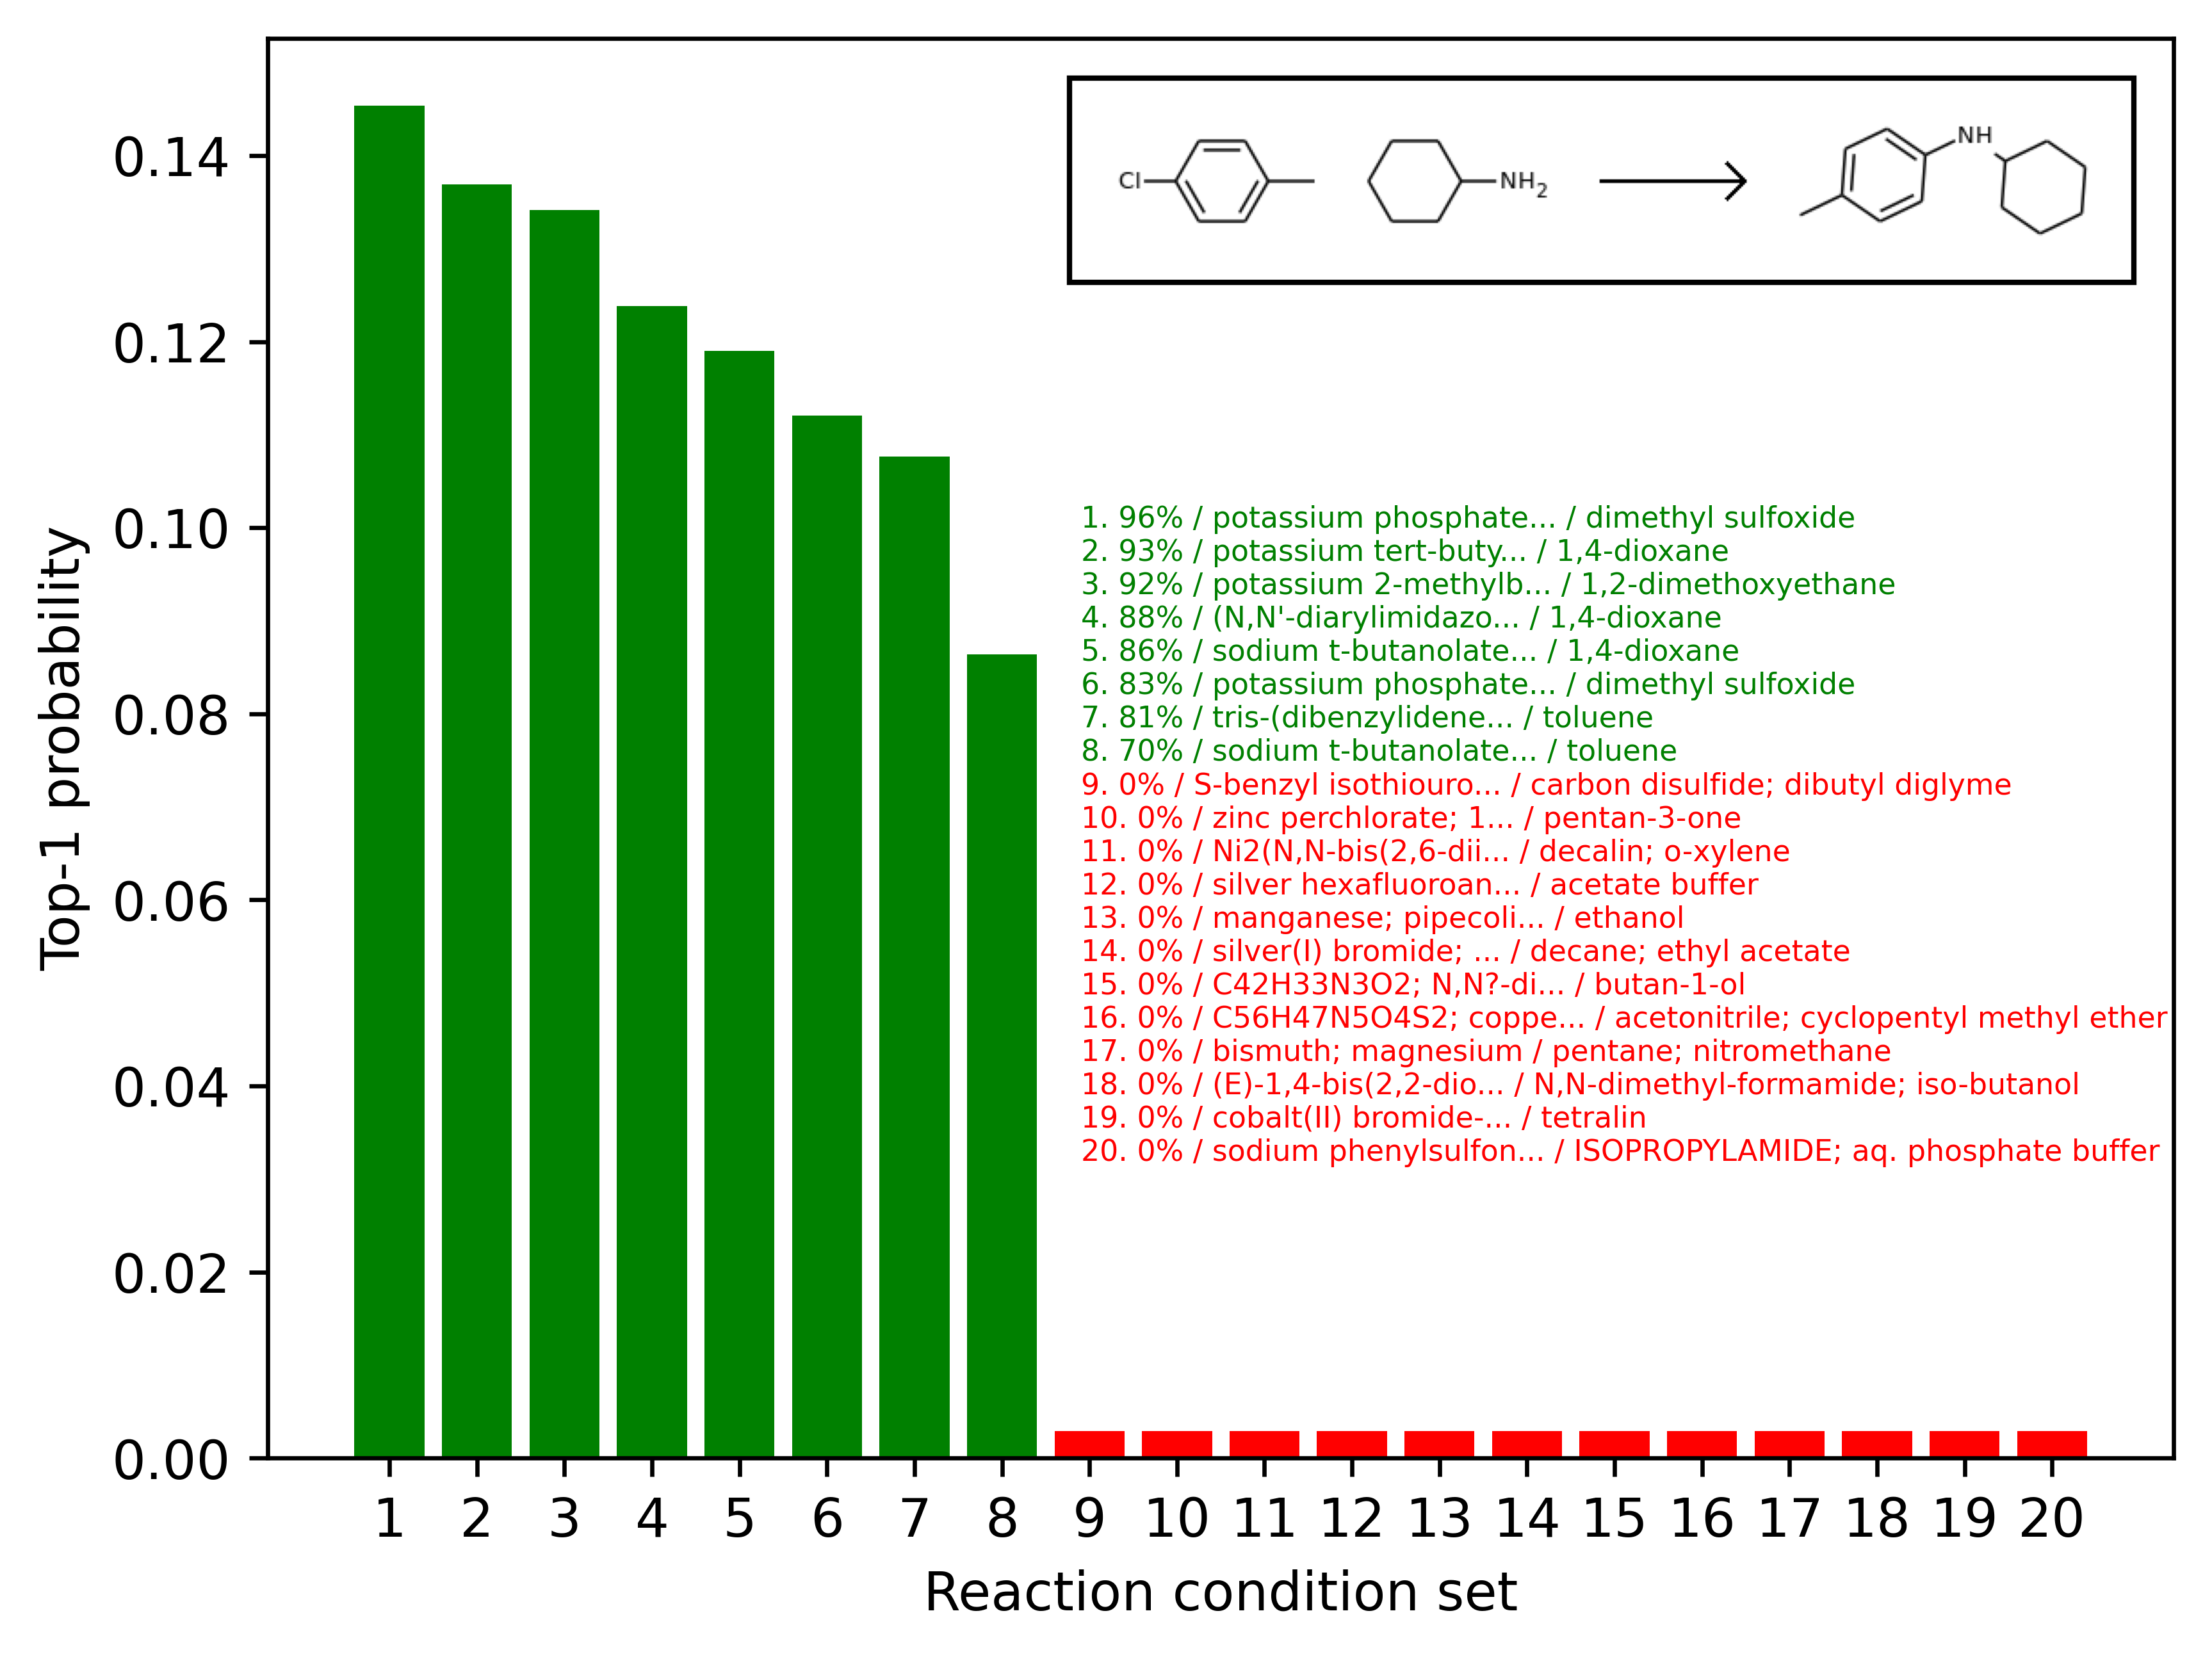

In [14]:
# 畫出轉換成relevance scores 然後exp後的distribution，機率全部相加等於1，此外，也sample false reaction conditions
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(dpi=600)

arr_img = plt.imread('reaction_id_9079015.jfif')
im = OffsetImage(arr_img, zoom=0.34)
ab = AnnotationBbox(im, (0.7, 0.9), xycoords='axes fraction')
ax.add_artist(ab)

x1 = list(range(1,num_reals + 1))
x2 = list(range(num_reals+1, len(yield_distribution) + 1))
plt.bar(x1, yield_distribution[:num_reals], color='green')
plt.bar(x2, yield_distribution[num_reals:], color='red')
plt.xlabel('Reaction condition set')
plt.ylabel('Top-1 probability')
plt.xticks(x1+x2)


font_real = {#'family': 'serif',
        'color':  'green',
        'weight': 'normal',
        'size': 5.5,
        }
font_fake = {#'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 5.5,
        }
plt.text(x=8.9, y=0.06 + 0.015, s=texts_real, fontdict=font_real)
plt.text(x=8.9, y=0.017 + 0.015, s=texts_fake, fontdict=font_fake)
# plt.legend(['Real', 'Sampled fake'])